## Colab setup (optional)
Run this cell on Google Colab to mount Drive and set the working directory to your repo root. Edit `repo_path` to match your Drive path.

## Install required packages (Colab)
If you run this on Colab and packages are missing, run the install cell. On local machines, use your environment's package manager.

In [ ]:
!pip install tabulate seaborn matplotlib pandas numpy

## Imports and helper setup
The following cell contains only the imports from your original script (no added validation).

In [11]:
import sqlite3
from tabulate import tabulate     
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import seaborn as sns
from premier_league import RankingTable
from premier_league import MatchStatistics

## Connect to the SQLite DB and inspect tables
This matches the script's initial DB inspection. Ensure `data/premier_league.db` exists relative to the repository root.

In [12]:
conn = sqlite3.connect("data/premier_league.db")
cursor = conn.cursor()
# Print all table names
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
db_tables = cursor.fetchall()
print("Table names:", [table[0] for table in db_tables])

Table names: ['league', 'team', 'game', 'game_stats', 'sqlite_sequence']


## Latest 5 Premier League games (example query)
Prints a quick sample of recent games as in the script.

In [13]:
cursor.execute("""
    SELECT g.*,  t.name as home_team_name, t2.name as away_team_name 
    FROM game g
    JOIN team t ON g.home_team_id = t.id
    JOIN team t2 ON g.away_team_id = t2.id
    WHERE g.league_id = 1
    ORDER BY g.date DESC
    LIMIT 5
""")
latest_games = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]
print('Latest 5 games:')
print(tabulate(latest_games, headers=column_names, tablefmt="pretty"))

Latest 5 games:
+----------+--------------+--------------+-----------+------------+------------+------------------+------------------+----------------------------+------------+-----------+-------------------+-------------------------+
|    id    | home_team_id | away_team_id | league_id | home_goals | away_goals | home_team_points | away_team_points |            date            | match_week |  season   |  home_team_name   |     away_team_name      |
+----------+--------------+--------------+-----------+------------+------------+------------------+------------------+----------------------------+------------+-----------+-------------------+-------------------------+
| 6a433468 |   b8fd03ef   |   8cec06e1   |     1     |     1      |     0      |        64        |        41        | 2025-05-02 20:00:00.000000 |     35     | 2024-2025 |  Manchester City  | Wolverhampton Wanderers |
| a896a308 |   e4a775cb   |   cd051869   |     1     |     0      |     2      |        60        |        4

## Aggregated season totals per team
Compute per-team totals for goals and xG as in the script.

In [14]:
cursor.execute('''
    SELECT
        t.name,
        SUM(CASE WHEN g.home_team_id = t.id THEN g.home_goals ELSE g.away_goals END) AS goals_for,
        SUM(CASE WHEN g.home_team_id = t.id THEN g.away_goals ELSE g.home_goals END) AS goals_against,
        SUM(gs.xg) AS xg
    FROM team t
    JOIN game g ON (t.id = g.home_team_id OR t.id = g.away_team_id)
    LEFT JOIN game_stats gs ON gs.game_id = g.id AND gs.team_id = t.id
    WHERE g.league_id = 1 AND g.season = '2023-2024'
    GROUP BY t.name
    ORDER BY t.name
''')
agg_results = cursor.fetchall()
agg_columns = [desc[0] for desc in cursor.description]
print('Aggregated: Team, goals_for, goals_against, xg (all games, league_id=1, season=2023-2024):')
print(tabulate(agg_results, headers=agg_columns, tablefmt="pretty"))

conn.close()

Aggregated: Team, goals_for, goals_against, xg (all games, league_id=1, season=2023-2024):
+-------------------------+-----------+---------------+--------------------+
|          name           | goals_for | goals_against |         xg         |
+-------------------------+-----------+---------------+--------------------+
|         Arsenal         |    91     |      29       | 78.39999999999999  |
|       Aston Villa       |    76     |      61       |        67.8        |
|       Bournemouth       |    54     |      67       |        57.2        |
|        Brentford        |    56     |      65       | 63.300000000000004 |
| Brighton & Hove Albion  |    55     |      62       |        58.8        |
|         Burnley         |    41     |      78       |        41.1        |
|         Chelsea         |    77     |      63       |        77.1        |
|     Crystal Palace      |    57     |      58       |        50.8        |
|         Everton         |    40     |      51       |       

## Build ranking table and merge xG/GF/GA
This section uses the `RankingTable` from the local `premier_league` module and merges the aggregated totals.

In [16]:
ranking = RankingTable(target_season="2023-2024")
ranking_list = ranking.get_ranking_list()
# assume the first row is a header and the rest are rows
header = ranking_list[0]
rows = ranking_list[1:]
ranking_df = pd.DataFrame(rows, columns=header)
print(ranking_df.to_string(index=False))

# Merge aggregated season totals (GF/GA/xG) into the ranking dataframe
agg_df = pd.DataFrame(agg_results, columns=agg_columns)
# find the ranking dataframe column that contains the team name
team_col = next(c for c in ranking_df.columns if 'team' in c.lower() or 'club' in c.lower())
# merge on team name
merged = ranking_df.merge(agg_df, left_on=team_col, right_on='name', how='left')
# add key metrics to the ranking table (xG, GF, GA)
ranking_df['xG'] = merged['xg'].round(1)
ranking_df['GF'] = merged['goals_for']
ranking_df['GA'] = merged['goals_against']
print(ranking_df.to_string(index=False))

Pos                    Team Pld  W  D  L GF  GA  GD Pts
  1         Manchester City  38 28  7  3 96  34 +62  91
  2                 Arsenal  38 28  5  5 91  29 +62  89
  3               Liverpool  38 24 10  4 86  41 +45  82
  4             Aston Villa  38 20  8 10 76  61 +15  68
  5       Tottenham Hotspur  38 20  6 12 74  61 +13  66
  6                 Chelsea  38 18  9 11 77  63 +14  63
  7        Newcastle United  38 18  6 14 85  62 +23  60
  8       Manchester United  38 18  6 14 57  58  −1  60
  9         West Ham United  38 14 10 14 60  74 −14  52
 10          Crystal Palace  38 13 10 15 57  58  −1  49
 11  Brighton & Hove Albion  38 12 12 14 55  62  −7  48
 12             Bournemouth  38 13  9 16 54  67 −13  48
 13                  Fulham  38 13  8 17 55  61  −6  47
 14 Wolverhampton Wanderers  38 13  7 18 50  65 −15  46
 15                 Everton  38 13  9 16 40  51 −11  40
 16               Brentford  38 10  9 19 56  65  −9  39
 17       Nottingham Forest  38  9  9 20 49  67 

## Missing data heatmap
Visual check for missing xG values in the league table.

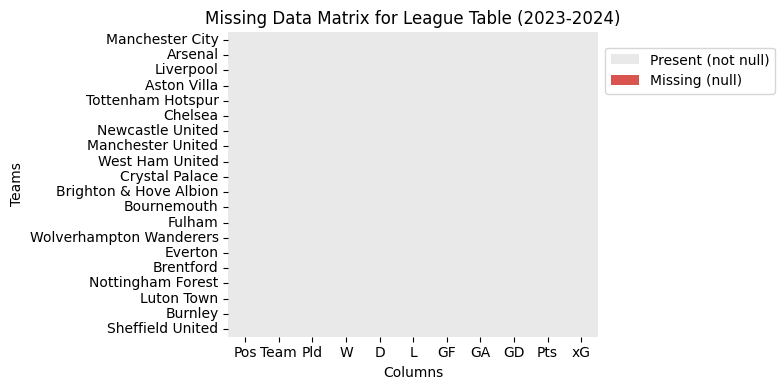

In [17]:
league_df = pd.DataFrame(ranking_df, columns=ranking_df.columns)
missing_xg = league_df[league_df['xG'].isnull()]
plt.figure(figsize=(8, 4))
present_color = '#e9e9e9'
missing_color = '#d9534f'
cmap = ListedColormap([present_color, missing_color])
ax = sns.heatmap(league_df.isnull().astype(int), cbar=False, yticklabels=league_df['Team'], cmap=cmap)
legend_handles = [
    Patch(facecolor=present_color, edgecolor='none', label='Present (not null)'),
    Patch(facecolor=missing_color, edgecolor='none', label='Missing (null)')
]
ax.legend(handles=legend_handles, bbox_to_anchor=(1.02, 0.95), loc='upper left', borderaxespad=0.)
plt.title('Missing Data Matrix for League Table (2023-2024)')
plt.xlabel('Columns')
plt.ylabel('Teams')
plt.tight_layout()
plt.show()

## Slopechart: Goals For vs xG by Team
Draws the slopechart comparing GF and xG ordered by league position.

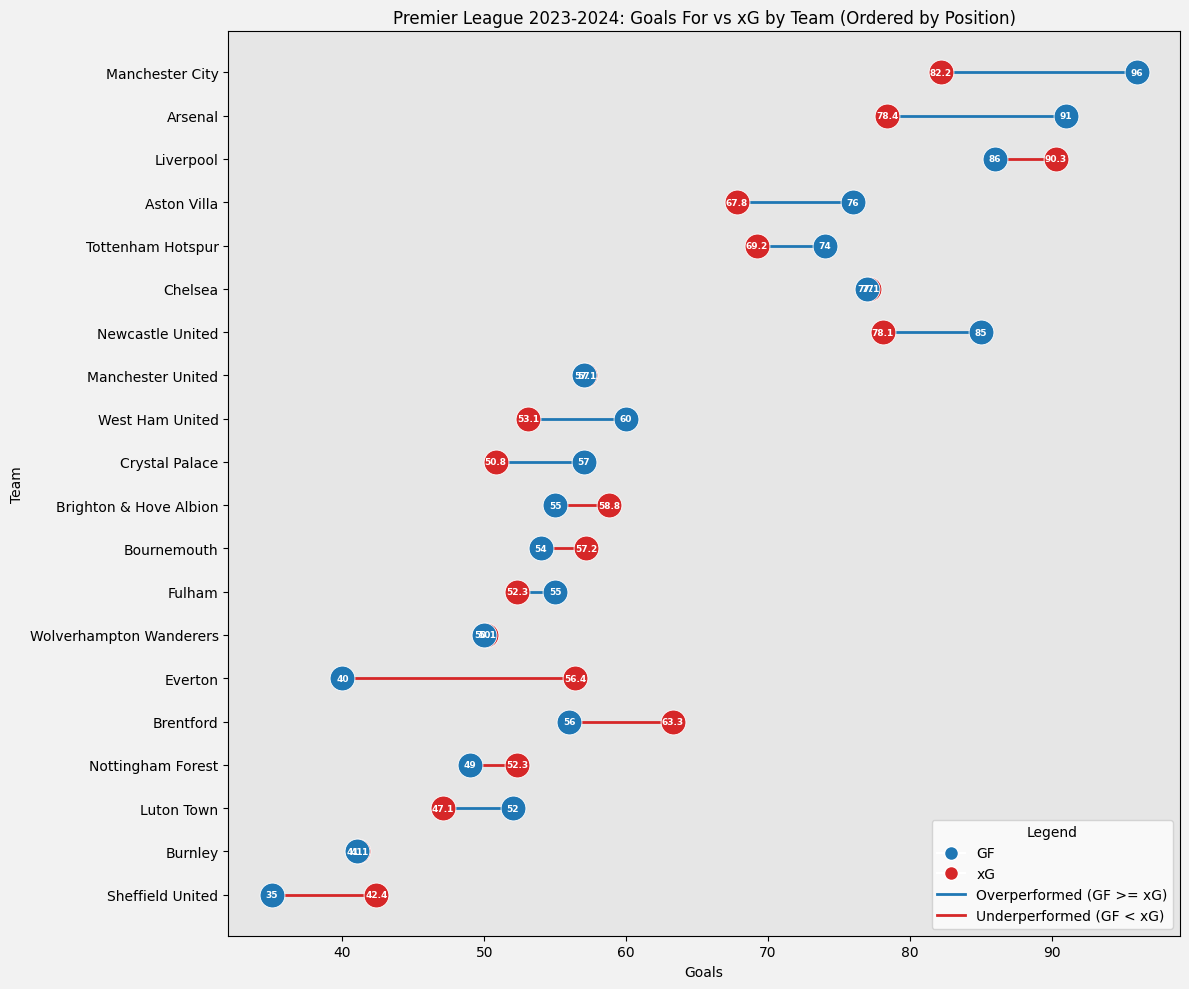

In [19]:
slope_df = pd.DataFrame(ranking_df, columns=ranking_df.columns)
pos_col = next((c for c in slope_df.columns if 'pos' in c.lower()), 'Pos')
slope_df[pos_col] = pd.to_numeric(slope_df[pos_col], errors='coerce')
slope_df = slope_df.sort_values(by=pos_col)
teams_ordered = list(slope_df['Team'])[::-1]  # Top team at top
y_pos = range(len(teams_ordered))
fig, ax = plt.subplots(figsize=(12, 10), facecolor='#f2f2f2')
ax.set_facecolor('#e6e6e6')
plt.title('Premier League 2023-2024: Goals For vs xG by Team (Ordered by Position)')
plt.xlabel('Goals')
plt.ylabel('Team')
marker_size = 320
txt_fontsize = 6.5
for i, row in enumerate(slope_df[::-1].itertuples()):  # reverse for top-to-bottom
    overperf = (row.GF >= row.xG)
    line_color = 'tab:blue' if overperf else 'tab:red'
    plt.plot([row.xG, row.GF], [i, i], color=line_color, linewidth=2, zorder=1)
    plt.scatter(row.xG, i, color='tab:red', s=marker_size, edgecolors='white', linewidths=0.6, zorder=3)
    plt.scatter(row.GF, i, color='tab:blue', s=marker_size, edgecolors='white', linewidths=0.6, zorder=3)
    plt.text(row.xG, i, f"{row.xG}", fontsize=txt_fontsize, ha='center', va='center', color='white', fontweight='bold', zorder=4)
    plt.text(row.GF, i, f"{row.GF}", fontsize=txt_fontsize, ha='center', va='center', color='white', fontweight='bold', zorder=4)
plt.yticks(y_pos, teams_ordered)
legend_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:blue', markersize=10, label='GF'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:red', markersize=10, label='xG'),
    Line2D([0], [0], color='tab:blue', lw=2, label='Overperformed (GF >= xG)'),
    Line2D([0], [0], color='tab:red', lw=2, label='Underperformed (GF < xG)')
]
plt.legend(handles=legend_handles, loc='lower right', title='Legend')
plt.tight_layout()
plt.show()

## Classify overperformers / underperformers
List teams where GF >= xG and GF < xG, respectively.

In [20]:
ranking_df['GF'] = pd.to_numeric(ranking_df['GF'])
ranking_df['xG'] = pd.to_numeric(ranking_df['xG'])
ranking_df['diff'] = ranking_df['GF'] - ranking_df['xG']
overperformers = ranking_df[~ranking_df['xG'].isnull()].loc[ranking_df['diff'] >= 0, ['Team','GF','xG','diff']]
underperformers = ranking_df[~ranking_df['xG'].isnull()].loc[ranking_df['diff'] < 0, ['Team','GF','xG','diff']]
print('Teams that OVERPERFORMED (GF >= xG):')
for _, r in overperformers.sort_values(by='diff', ascending=False).iterrows():
    print(f"  {r['Team']}: GF={int(r['GF'])}, xG={r['xG']:.1f}, diff={r['diff']:.1f}")
print('Teams that UNDERPERFORMED (GF < xG):')
for _, r in underperformers.sort_values(by='diff').iterrows():
    print(f"  {r['Team']}: GF={int(r['GF'])}, xG={r['xG']:.1f}, diff={r['diff']:.1f}")

Teams that OVERPERFORMED (GF >= xG):
  Manchester City: GF=96, xG=82.2, diff=13.8
  Arsenal: GF=91, xG=78.4, diff=12.6
  Aston Villa: GF=76, xG=67.8, diff=8.2
  Newcastle United: GF=85, xG=78.1, diff=6.9
  West Ham United: GF=60, xG=53.1, diff=6.9
  Crystal Palace: GF=57, xG=50.8, diff=6.2
  Luton Town: GF=52, xG=47.1, diff=4.9
  Tottenham Hotspur: GF=74, xG=69.2, diff=4.8
  Fulham: GF=55, xG=52.3, diff=2.7
Teams that UNDERPERFORMED (GF < xG):
  Everton: GF=40, xG=56.4, diff=-16.4
  Sheffield United: GF=35, xG=42.4, diff=-7.4
  Brentford: GF=56, xG=63.3, diff=-7.3
  Liverpool: GF=86, xG=90.3, diff=-4.3
  Brighton & Hove Albion: GF=55, xG=58.8, diff=-3.8
  Nottingham Forest: GF=49, xG=52.3, diff=-3.3
  Bournemouth: GF=54, xG=57.2, diff=-3.2
  Manchester United: GF=57, xG=57.1, diff=-0.1
  Burnley: GF=41, xG=41.1, diff=-0.1
  Wolverhampton Wanderers: GF=50, xG=50.1, diff=-0.1
  Chelsea: GF=77, xG=77.1, diff=-0.1


## Scatterplot: Final Position vs (GF - xG)
Shows the relationship between final position and over/under performance.

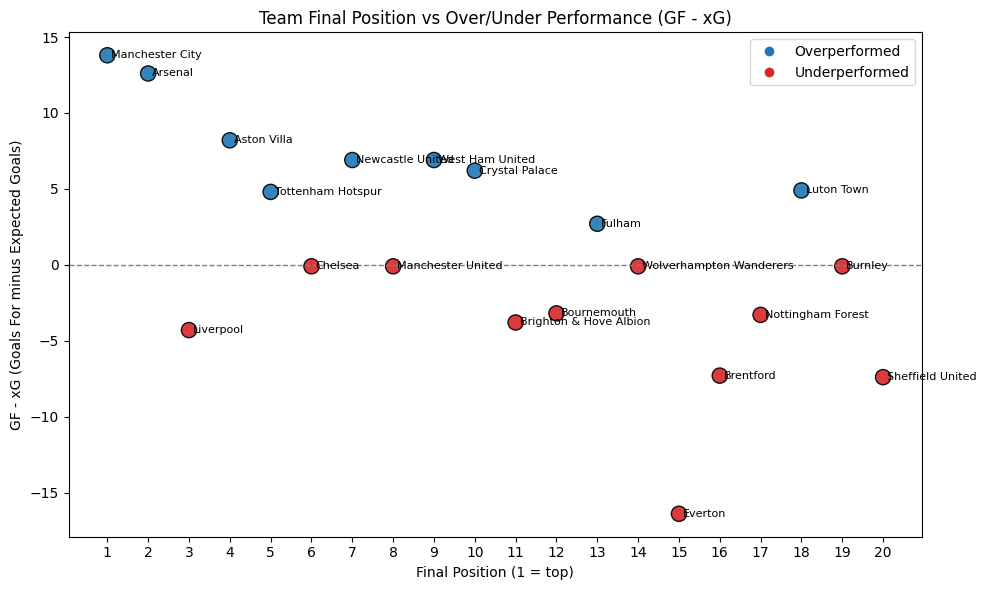

In [21]:
pos_col = next((c for c in ranking_df.columns if 'pos' in c.lower()), 'Pos')
plot_df = ranking_df.copy()
plot_df['perf'] = np.where(plot_df['diff'] >= 0, 'Over', 'Under')
xpos = pd.to_numeric(plot_df[pos_col], errors='coerce')
plt.figure(figsize=(10, 6))
colors = {'Over': 'tab:blue', 'Under': 'tab:red'}
plt.scatter(xpos, plot_df['diff'], c=plot_df['perf'].map(colors), s=120, alpha=0.9, edgecolor='k')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Final Position (1 = top)')
plt.ylabel('GF - xG (Goals For minus Expected Goals)')
plt.title('Team Final Position vs Over/Under Performance (GF - xG)')
pos_ticks = sorted(xpos.dropna().unique())
plt.xticks(pos_ticks)
for x, team, diff in zip(xpos, plot_df['Team'], plot_df['diff']):
    plt.text(x + 0.1, diff, team, fontsize=8, va='center')
legend_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:blue', markersize=8, label='Overperformed'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:red', markersize=8, label='Underperformed')
]
plt.legend(handles=legend_handles, loc='best')
plt.tight_layout()
plt.show()